# What is RNN?
RNN (Recurrent Neural Network) is a type of neural network designed to process sequential data by maintaining a memory of previous inputs through internal loops.

Unlike traditional neural networks (which assume all inputs are independent), RNNs handle input sequences (e.g., time series, text) where the order matters.

# why RNN?

- Sequential Data Handling
RNNs are specifically designed for tasks where data comes in a sequence — such as:

Words in a sentence

Time-stamped stock prices

Audio signals

- Context Awareness
At each step, an RNN considers not only the current input but also the "context" from the previous steps. This helps in:

Language modeling (predicting the next word)

Sentiment analysis (understanding tone over the whole sentence)

Speech recognition (understanding phoneme sequences)

- Parameter Sharing
RNNs reuse the same weights across all time steps, which reduces the number of parameters and allows them to generalize better over different sequence lengths.

# Get Setup

In [2]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
from torchinfo import summary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Get Data

In [4]:
pip install gdown


  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)

   ----- ---------------------------------- 1/8 [PySocks]
   ---------- ----------------------------- 2/8 [idna]
   ---------- ----------------------------- 2/8 [idna]
   --------------- ------------------------ 3/8 [charset-normalizer]
   ------------------------- -------------- 5/8 [requests]
   ------------------------- -------------- 5/8 [requests]
   ------------------------------ --------- 6/8 [beautifulsoup4]
   ------------------------------ --------- 6/8 [beautifulsoup4]
   ------------------------------ --------- 6/8 [beautifulsoup4]
   ------------------------------ --------- 6/8 [beautifulsoup4]
   ----------------------------------- ---- 7/8 [gdown]
   ----------------------------------- ---- 7/8 [gdown]
   ---------------------------------------- 8/8 [gdown]

Note: you may need to restart the kernel t

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.18.0 requires absl-py>=1.0.0, which is not installed.
tensorflow-intel 2.18.0 requires astunparse>=1.6.0, which is not installed.
tensorflow-intel 2.18.0 requires flatbuffers>=24.3.25, which is not installed.
tensorflow-intel 2.18.0 requires gast!=0.5.0,!=0.5.1,!=0.5.2,>=0.2.1, which is not installed.
tensorflow-intel 2.18.0 requires google-pasta>=0.1.1, which is not installed.
tensorflow-intel 2.18.0 requires grpcio<2.0,>=1.24.3, which is not installed.
tensorflow-intel 2.18.0 requires h5py>=3.11.0, which is not installed.
tensorflow-intel 2.18.0 requires keras>=3.5.0, which is not installed.
tensorflow-intel 2.18.0 requires libclang>=13.0.0, which is not installed.
tensorflow-intel 2.18.0 requires ml-dtypes<0.5.0,>=0.4.0, which is not installed.
tensorflow-intel 2.18.0 requires opt-einsum>=2.3

In [19]:
import os
import gdown
import zipfile
from pathlib import Path

data_path = Path('dataset')
data_path.mkdir(exist_ok=True)

drive_url = 'https://drive.google.com/file/d/1X4Hcj72NK7J2JYvgjICFj0R1XwUq1w0a/view'
id = drive_url.split('/')[5]
final_url = f"https://drive.google.com/uc?id={id}"
output_file = data_path / 'seq_dataset'
gdown.download(final_url, str(output_file), quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1X4Hcj72NK7J2JYvgjICFj0R1XwUq1w0a
To: e:\python\pytorch\dataset\seq_dataset




100%|██████████| 4.28k/4.28k [00:00<00:00, 3.63MB/s]


'dataset\\seq_dataset'

In [20]:
import pandas as pd
df = pd.read_csv(output_file)

In [21]:
df.head()

,question,answer
0,What is the capital of France?,Paris
1,What is the capital of Germany?,Berlin
2,Who wrote 'To Kill a Mockingbird'?,Harper-Lee
3,What is the largest planet in our solar system?,Jupiter
4,What is the boiling point of water in Celsius?,100


# Text Preprocessing

## Tokanization of Data
Tokenization is the process of breaking down a large piece of text into smaller units called tokens.

example - "Tokenization is important" → ["Tokenization", "is", "important"]

## Why is Tokenization Important?
Tokenization is a fundamental step in Natural Language Processing (NLP) because machines don’t understand raw text—they need structured data. Tokenization helps by:

Preparing text for further processing (e.g., word embeddings, parsing).

Helping models understand the structure and meaning of text.

In [22]:
def toakenizer(text):
    text = text.lower()
    text = text.replace('?','')
    text = text.replace("'","")
    return text.split()

In [23]:
toakenizer('What is the largest planet in our solar system?')

['what', 'is', 'the', 'largest', 'planet', 'in', 'our', 'solar', 'system']

In [24]:
vocab = {'<UNK>':0}

def build_vocab(row):
  tokenized_question = toakenizer(row['question'])
  tokenized_answer = toakenizer(row['answer'])

  merged_tokens = tokenized_question + tokenized_answer

  for token in merged_tokens:

    if token not in vocab:
      vocab[token] = len(vocab)


In [25]:
df.apply(build_vocab, axis=1)

0     None
1     None
2     None
3     None
4     None
      ... 
85    None
86    None
87    None
88    None
89    None
Length: 90, dtype: object

In [26]:
len(vocab)

324

In [27]:
df.head()

,question,answer
0,What is the capital of France?,Paris
1,What is the capital of Germany?,Berlin
2,Who wrote 'To Kill a Mockingbird'?,Harper-Lee
3,What is the largest planet in our solar system?,Jupiter
4,What is the boiling point of water in Celsius?,100


# Create Dataset and Dataloader

In [28]:
from torch.utils.data import DataLoader,Dataset

In [35]:
# convert words to numerical indices
def text_to_indices(text, vocab):

  indexed_text = []

  for token in toakenizer(text):

    if token in vocab:
      indexed_text.append(vocab[token])
    else:
      indexed_text.append(vocab['<UNK>'])

  return indexed_text

In [36]:
class customDataset(Dataset):
    def __init__(self, df, vocab):
        self.df = df
        self.vocab = vocab

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        numerical_question = text_to_indices(self.df.iloc[index]['question'], self.vocab)
        numerical_answer = text_to_indices(self.df.iloc[index]['answer'], self.vocab)
        return torch.tensor(numerical_question), torch.tensor(numerical_answer)

In [37]:
dataset = customDataset(df,vocab)

In [38]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [39]:
for question, answer in dataloader:
  print(question, answer[0])

tensor([[ 42,  18,   2,   3, 281,  12,   3, 282]]) tensor([205])
tensor([[ 42, 250, 251, 118, 252, 253]]) tensor([254])
tensor([[ 42, 101,   2,   3,  17]]) tensor([102])
tensor([[ 1,  2,  3,  4,  5, 73]]) tensor([74])
tensor([[  1,   2,   3,  33,  34,   5, 245]]) tensor([246])
tensor([[ 42,   2,   3, 210, 137, 168, 211, 169]]) tensor([113])
tensor([[42, 86, 87, 88, 89, 39, 90]]) tensor([91])
tensor([[ 78,  79, 261, 151,  14, 262, 153]]) tensor([36])
tensor([[ 42, 299, 300, 118,  14, 301, 302, 158, 303, 304, 305, 306]]) tensor([307])
tensor([[ 42, 137,   2, 226,  12,   3, 227, 228]]) tensor([155])
tensor([[ 10, 140,   3, 141, 270,  93, 271,   5,   3, 272]]) tensor([273])
tensor([[ 42, 137,   2, 138,  39, 139]]) tensor([53])
tensor([[ 1,  2,  3, 50, 51, 19,  3, 45]]) tensor([52])
tensor([[ 42, 107,   2, 108,  19, 109]]) tensor([110])
tensor([[  1,   2,   3, 234,   5, 235]]) tensor([131])
tensor([[ 78,  79, 195,  81,  19,   3, 196, 197, 198]]) tensor([199])
tensor([[ 10,   2,  62,  63,   

# Model Build

In [40]:
class simpleRNN(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size,embedding_dim=50)
        self.rnn = nn.RNN(input_size=50,hidden_size=64,batch_first=True)
        self.fc = nn.Linear(in_features=64,out_features=vocab_size)
        
    def forward(self,x):
      embedding_ques = self.embedding(x)
      hidden, final = self.rnn(embedding_ques)
      output = self.fc(final.squeeze(0))
      return output

In [41]:
x = nn.Embedding(324, embedding_dim=50)
y = nn.RNN(50, 64, batch_first=True)
z = nn.Linear(64, 324)

a = dataset[0][0].reshape(1,6)
print("shape of a:", a.shape)
b = x(a)
print("shape of b:", b.shape)
c, d = y(b)
print("shape of c:", c.shape)
print("shape of d:", d.shape)

e = z(d.squeeze(0))

print("shape of e:", e.shape)

shape of a: torch.Size([1, 6])
shape of b: torch.Size([1, 6, 50])
shape of c: torch.Size([1, 6, 64])
shape of d: torch.Size([1, 1, 64])
shape of e: torch.Size([1, 324])


In [43]:
model = simpleRNN(vocab_size=len(vocab))

In [45]:
import torch.optim.adam


lr =0.01
epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [46]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
simpleRNN                                --
├─Embedding: 1-1                         16,200
├─RNN: 1-2                               7,424
├─Linear: 1-3                            21,060
Total params: 44,684
Trainable params: 44,684
Non-trainable params: 0

# Train and Evaluate

In [62]:
import torch
from torch import nn
from torch.utils.data import DataLoader

def train_rnn(
    model: nn.Module,
    dataloader: DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device):

    model.train()
    total_loss, total_accuracy = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        # Move inputs and labels to the device
        x, y = x.to(device), y.to(device)

        # Optional: initialize hidden state for RNN (if needed)
        # hidden = model.init_hidden(x.size(0))  # Uncomment if your model needs it

        # Forward pass
        y_pred = model(x)  # (batch_size, output_dim) or (batch_size, seq_len, output_dim)

        # If output is (batch, seq_len, output_dim), take final timestep
        if len(y_pred.shape) == 3:
            y_pred = y_pred[:, -1, :]  # last time step output for classification

        loss = loss_fn(y_pred, y[0])
        total_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        total_accuracy += (y_pred_class == y).sum().item() / len(y)

    total_loss /= len(dataloader)
    total_accuracy /= len(dataloader)

    return total_loss, total_accuracy


In [65]:
from tqdm.auto import tqdm

def model_train(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    epochs: int,
    device: torch.device):  # Added device
     
    result = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        # Training phase
        train_loss, train_acc = train_rnn(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )

        # Evaluation phase
        model.eval()
        total_test_loss, total_test_acc = 0, 0
        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.to(device), y.to(device)
                y_pred = model(x)

                # If output is (batch, seq_len, output_dim), take last timestep
                if len(y_pred.shape) == 3:
                    y_pred = y_pred[:, -1, :]

                loss = loss_fn(y_pred, y[0])
                total_test_loss += loss.item()

                y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
                total_test_acc += (y_pred_class == y).sum().item() / len(y)

      

        print(f"Epoch: {epoch+1} | Train_loss: {train_loss:.4f} | Train_acc: {train_acc:.4f}")

        result["train_loss"].append(train_loss)
        result["train_acc"].append(train_acc)
     
    return result


In [66]:
# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_v1
model_v1_results = model_train(
    model=model,
    train_dataloader=dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    device=device  # Required argument
)

# End the timer and print how long it took
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")


  5%|▌         | 1/20 [00:00<00:14,  1.33it/s]

Epoch: 1 | Train_loss: 3.2839 | Train_acc: 0.2000


 10%|█         | 2/20 [00:01<00:12,  1.41it/s]

Epoch: 2 | Train_loss: 1.4382 | Train_acc: 0.6667


 15%|█▌        | 3/20 [00:02<00:11,  1.45it/s]

Epoch: 3 | Train_loss: 0.7066 | Train_acc: 0.8556


 20%|██        | 4/20 [00:02<00:11,  1.37it/s]

Epoch: 4 | Train_loss: 0.6054 | Train_acc: 0.8778


 25%|██▌       | 5/20 [00:03<00:10,  1.37it/s]

Epoch: 5 | Train_loss: 0.3965 | Train_acc: 0.9333


 30%|███       | 6/20 [00:04<00:10,  1.31it/s]

Epoch: 6 | Train_loss: 0.3033 | Train_acc: 0.9222


 35%|███▌      | 7/20 [00:05<00:09,  1.35it/s]

Epoch: 7 | Train_loss: 0.1509 | Train_acc: 0.9667


 40%|████      | 8/20 [00:05<00:08,  1.40it/s]

Epoch: 8 | Train_loss: 0.2575 | Train_acc: 0.9667


 45%|████▌     | 9/20 [00:06<00:07,  1.44it/s]

Epoch: 9 | Train_loss: 0.1338 | Train_acc: 0.9556


 50%|█████     | 10/20 [00:07<00:06,  1.47it/s]

Epoch: 10 | Train_loss: 0.1602 | Train_acc: 0.9667


 55%|█████▌    | 11/20 [00:07<00:06,  1.47it/s]

Epoch: 11 | Train_loss: 0.1742 | Train_acc: 0.9778


 60%|██████    | 12/20 [00:08<00:05,  1.49it/s]

Epoch: 12 | Train_loss: 0.0982 | Train_acc: 0.9778


 65%|██████▌   | 13/20 [00:09<00:04,  1.48it/s]

Epoch: 13 | Train_loss: 0.0670 | Train_acc: 0.9667


 70%|███████   | 14/20 [00:09<00:04,  1.37it/s]

Epoch: 14 | Train_loss: 0.2059 | Train_acc: 0.9667


 75%|███████▌  | 15/20 [00:10<00:03,  1.42it/s]

Epoch: 15 | Train_loss: 0.1065 | Train_acc: 0.9778


 80%|████████  | 16/20 [00:11<00:02,  1.43it/s]

Epoch: 16 | Train_loss: 0.0774 | Train_acc: 0.9667


 85%|████████▌ | 17/20 [00:12<00:02,  1.43it/s]

Epoch: 17 | Train_loss: 0.0300 | Train_acc: 0.9889


 90%|█████████ | 18/20 [00:12<00:01,  1.42it/s]

Epoch: 18 | Train_loss: 0.0058 | Train_acc: 1.0000


 95%|█████████▌| 19/20 [00:13<00:00,  1.40it/s]

Epoch: 19 | Train_loss: 0.0042 | Train_acc: 1.0000


100%|██████████| 20/20 [00:14<00:00,  1.38it/s]

Epoch: 20 | Train_loss: 0.0036 | Train_acc: 1.0000
Total training time: 14.518 seconds


In [70]:
model_v1_results

{'train_loss': [3.2838716049989065,
  1.4381529585354857,
  0.7065615872128143,
  0.6054466353470667,
  0.39653161028400064,
  0.303260908772548,
  0.1509299762184835,
  0.25751233755403924,
  0.13378717731167045,
  0.16020255635440764,
  0.1742037872214698,
  0.09815009243450024,
  0.06699410813679504,
  0.2058886528254435,
  0.10648242917118801,
  0.07735284959716308,
  0.03001799303520885,
  0.005808255795596374,
  0.0042007795910144015,
  0.0035676745102844304],
 'train_acc': [0.2,
  0.6666666666666666,
  0.8555555555555555,
  0.8777777777777778,
  0.9333333333333333,
  0.9222222222222223,
  0.9666666666666667,
  0.9666666666666667,
  0.9555555555555556,
  0.9666666666666667,
  0.9777777777777777,
  0.9777777777777777,
  0.9666666666666667,
  0.9666666666666667,
  0.9777777777777777,
  0.9666666666666667,
  0.9888888888888889,
  1.0,
  1.0,
  1.0],
 'test_loss': [],
 'test_acc': []}

In [71]:
from typing import Dict , List
def plot_loss_curves(results: Dict[str, List[float]]):
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
   

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

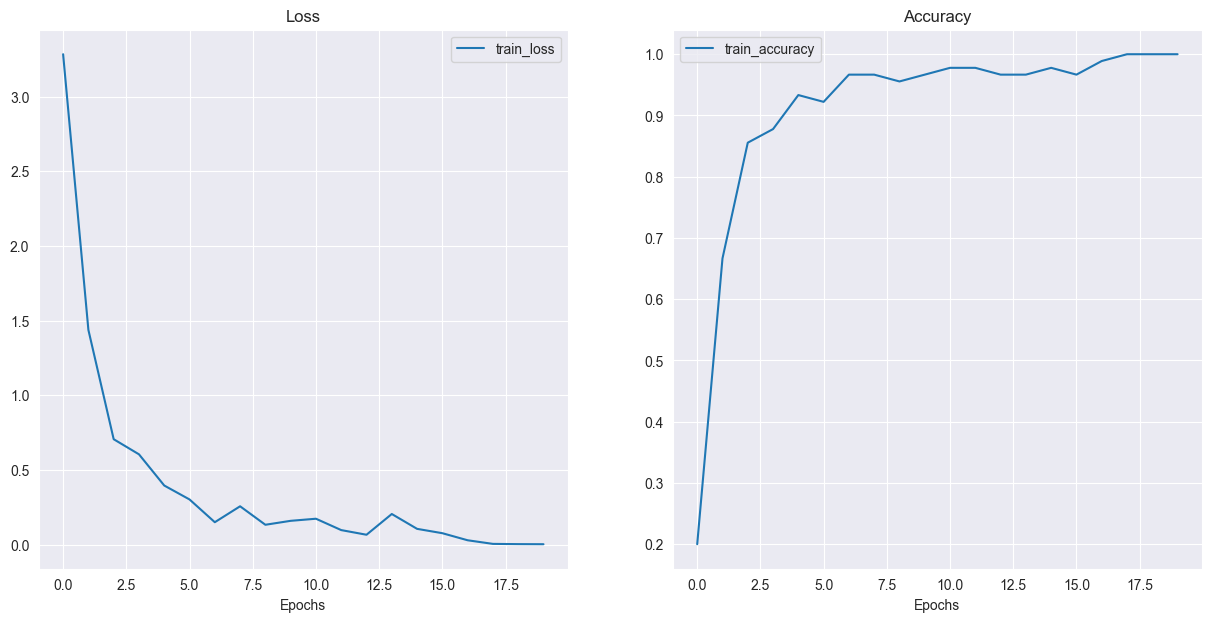

In [72]:
plot_loss_curves(model_v1_results)

# Infrance

In [67]:

def predict(model, question, threshold=0.5):

  # convert question to numbers
  numerical_question = text_to_indices(question, vocab)

  # tensor
  question_tensor = torch.tensor(numerical_question).unsqueeze(0)

  # send to model
  output = model(question_tensor)

  # convert logits to probs
  probs = torch.nn.functional.softmax(output, dim=1)

  # find index of max prob
  value, index = torch.max(probs, dim=1)

  if value < threshold:
    print("I don't know")

  print(list(vocab.keys())[index])

In [68]:
predict(model, "What is the largest planet in our solar system?")

jupiter


In [69]:
list(vocab.keys())[7]

'paris'